# Template Pipeline
Normalisation&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**X -> Gaussian**  
Imputation 1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Median**  
Outlier Detection&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Z Score**  
Imputation 2&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Median**  
Feature Selection&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Implicit to model**  
Model&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Lasso Regression**


## Imports

In [ ]:
!pip install tensorflow

     |████████████████████████████████| 320.4 MB 14 kB/s  eta 0:00:011  |                                | 215 kB 7.1 MB/s eta 0:00:46     |▏                               | 1.8 MB 7.1 MB/s eta 0:00:46     |▎                               | 2.4 MB 7.1 MB/s eta 0:00:46     |▍                               | 4.3 MB 7.1 MB/s eta 0:00:45     |▍                               | 4.4 MB 7.1 MB/s eta 0:00:45               | 6.8 MB 7.1 MB/s eta 0:00:45     |█▏                              | 11.4 MB 7.1 MB/s eta 0:00:44                    | 43.1 MB 7.1 MB/s eta 0:00:40         | 51.7 MB 78.7 MB/s eta 0:00:048.7 MB/s eta 0:00:04     | 59.2 MB 78.7 MB/s eta 0:00:04     |██████▏                         | 61.3 MB 78.7 MB/s eta 0:00:04     |███████▏                        | 71.9 MB 78.7 MB/s eta 0:00:04     |████████                        | 80.2 MB 78.6 MB/s eta 0:00:04     |█████████▊                      | 97.2 MB 78.6 MB/s eta 0:00:03     |█████████▊                      | 97.5 MB 78.6 MB/s eta 0:

In [ ]:
# General
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ML
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, BayesianRidge
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

import tensorflow as t
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import KFold
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, BatchNormalization
import sklearn
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
# Custom
import sys,os
sys.path.append('/home/jovyan/work/AML/Task_1/Solution') # I would like a cleaner solution but works for now
import Components.Imputation as Imputation
import Components.Outlier_Detection_1D as Outlier_Detection_1D
import Components.Outlier_Detection_ND as Outlier_Detection_ND
import Components.Feature_Selection as Feature_Selection
import Components.Normalisation as Normalisation
import Components.data_fetching as data_fetching
import Components.data_observations as data_observations

# CAREFUL:
# If you make changes to a custom module, you have to reload it, i.e rerun this cell
import importlib
importlib.reload(Imputation)
importlib.reload(Outlier_Detection_1D)
importlib.reload(Outlier_Detection_ND)
importlib.reload(Feature_Selection)
importlib.reload(Normalisation)
importlib.reload(data_fetching)
importlib.reload(data_observations)

<module 'Components.data_observations' from '/home/jovyan/work/AML/Task_1/Solution/Components/data_observations.py'>

## Data Cleaning

In [ ]:
verbose = True
X, y = data_fetching.get_train_data()

missing_vals_mask = Imputation.missing_values_mask(X)
X = Imputation.median(X)
#X,y, missing_vals_mask = Outlier_Detection_ND.mahalanobis_distance(X,y, missing_vals_mask, verbose=verbose)
X,y, missing_vals_mask = Outlier_Detection_ND.magic_indices(X,y, 10, missing_vals_mask,verbose=verbose)

X = Normalisation.gaussian(X)
X = Outlier_Detection_1D.z_score(X)
X = X.mask(missing_vals_mask) # Re-impute the ones we imputed before
X = Imputation.mean(X)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

# Outliers:  [ 323  333  215 1094 1179  774  527  826  981  673]


## Model Training

### Simple

In [ ]:
# welcome to the overfitting party!

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(32, input_dim=832, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    #model.add(Dense(64, input_dim=128, kernel_initializer='normal', kernel_regularizer=regularizers.l1(0.001)))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(16, input_dim=32, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[coeff_determination])
    return model
# evaluate model

reg_model = baseline_model()
reg_model.fit(x_train, y_train, batch_size=50, epochs=3000)
#estimator = KerasRegressor(build_fn=baseline_model, epochs=3500, batch_size=70, verbose=1)
kfold = KFold(n_splits=2)
#estimator.fit(x_train, y_train)
#results = cross_val_score(estimator, x_train, y_train, cv=kfold, scoring='r2')
#print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

print('Test Score')
y_pred_test = reg_model.predict(x_test)
test_score = r2_score(y_test, y_pred_test)
print(test_score)

21/21 [==============================] - 0s 2ms/step - loss: 58.1623 - coeff_determination: 0.4074
Epoch 2503/3000
21/21 [==============================] - 0s 2ms/step - loss: 57.5637 - coeff_determination: 0.4028
Epoch 2504/3000
21/21 [==============================] - 0s 5ms/step - loss: 53.3451 - coeff_determination: 0.4661
Epoch 2505/3000
21/21 [==============================] - 0s 3ms/step - loss: 54.0331 - coeff_determination: 0.4512
Epoch 2506/3000
21/21 [==============================] - 0s 4ms/step - loss: 53.9840 - coeff_determination: 0.4393
Epoch 2507/3000
21/21 [==============================] - 0s 5ms/step - loss: 51.5699 - coeff_determination: 0.4780
Epoch 2508/3000
21/21 [==============================] - 0s 3ms/step - loss: 48.9736 - coeff_determination: 0.5082
Epoch 2509/3000
21/21 [==============================] - 0s 2ms/step - loss: 55.9481 - coeff_determination: 0.4398
Epoch 2510/3000
21/21 [==============================] - 0s 2ms/step - loss: 59.2993 - coeff_det

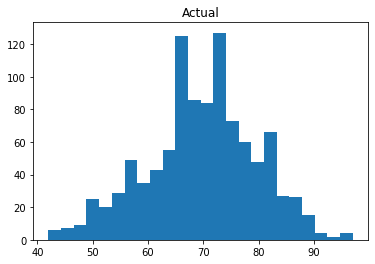

NameError: name 'y_pred_train' is not defined

In [ ]:
plt.hist(y_train.iloc[:,0].to_numpy(), bins='auto')
plt.title('Actual')
plt.show()

plt.hist(y_pred_train, bins='auto')
plt.title('Prediction')
plt.show()

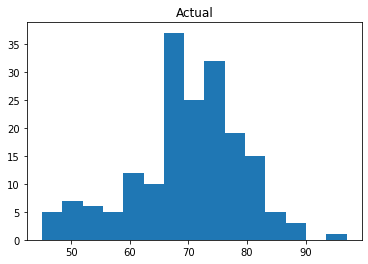

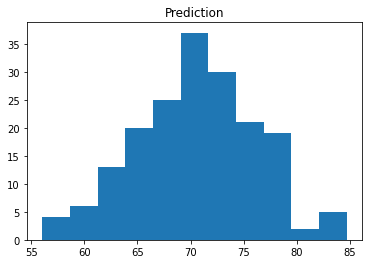

In [ ]:
plt.hist(y_test.iloc[:,0].to_numpy(), bins='auto')
plt.title('Actual')
plt.show()

plt.hist(y_pred_test, bins='auto')
plt.title('Prediction')
plt.show()

## Final Prediction

Test Score
16/16 [==============================] - 0s 1ms/step
0.9687478645321344
12/12 [==============================] - 0s 17ms/step
           y
0  65.919220
1  74.979790
2  63.795074
3  70.620720
4  70.801605


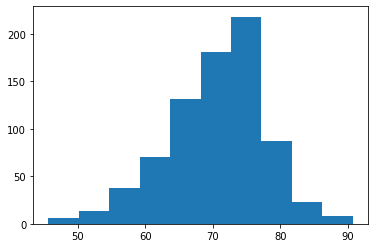

In [ ]:
# lasso_final = Lasso(normalize=False, max_iter=1000, alpha=0.35).fit(X, y)
#final = estimator.fit(X, y)
x_test = data_fetching.get_test_data()
print('Test Score')
y_pred_test = estimator.predict(X)
test_score = r2_score(y, y_pred_test)
print(test_score)
x_test = Imputation.mean(x_test)
x_test = Normalisation.gaussian(x_test)

# Note: They said no outliers were introduced in x_test so no need to perform outlier detection
y_pred = estimator.predict(x_test)
plt.hist(y_pred)

y_pred_pd = pd.DataFrame(data=y_pred, columns=["y"])
print(y_pred_pd.head())
y_pred_pd.to_csv('../../Predictions/nn.csv', index_label='id')